In [1]:
import numpy as np
import cv2
from skimage import color, io, filters
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import math
import matplotlib.image as mpimg
from skimage.metrics import structural_similarity as ssim
import warnings

# Color Compensation

In [2]:
def color_compensation(img):
    img = np.double(img)
    #print(img)
    R = img[:,:,0]
    G = img[:,:,1]
    B = img[:,:,2]
    Irm = np.mean(R, axis=0)
    Irm = np.mean(Irm)/256.0
    Igm = np.mean(G, axis=0)
    Igm = np.mean(Igm)/256.0
    Ibm = np.mean(B, axis=0)
    Ibm = np.mean(Ibm)/256.0
    a = 1.5
    Irc = R + a * (Igm-Irm)*(1-Irm)*G 
    Irc = np.array(Irc.reshape(G.shape), np.uint8)
    b=1
    Ibc = B + b* (Igm-Ibm)*(1-Ibm)*G
    Ibc = np.array(Ibc.reshape(G.shape), np.uint8)
    G = np.array(G,np.uint8)
    img = cv2.merge([Ibc,G,Irc])
    return img

# Color Correction

In [3]:
def single_scale_Retinex(raw_img, sigma):
    log_img = np.log10(raw_img) - np.log10(cv2.GaussianBlur(raw_img, (0, 0), sigma)) # sigma = 15
    return log_img


def multi_scale_Retinex(raw_img, sigma_arr, weight_arr):
    while len(weight_arr) < len(sigma_arr):
        weight_arr.append(0)
    weight_sum = sum(weight_arr)

    img = np.zeros(raw_img.shape)
    for i in range(len(sigma_arr)):
        w = weight_arr[i] / weight_sum
        img += single_scale_Retinex(raw_img, sigma_arr[i]) * w
    
    return img

def create_gamma_lookup_table(gamma):
    lut = list(range(0, 256))
    if gamma != 0:
        for i in range(0,256):
            lut[i] = int((i / 255) ** (1 / gamma) * 255)
    return lut



def quantify_log_image(img, high_clip=0.005, low_clip=0.005, gamma=0.45):
    lut = create_gamma_lookup_table(gamma)

    for c in range(img.shape[-1]):
        flatten = sorted(img[:,:,c].ravel())
        low = flatten[int(len(flatten) * low_clip)]
        high = flatten[int(len(flatten) * (1 - high_clip))]
        # plt.hist(flatten, 200, [min(flatten), max(flatten)])
        # plt.show()
        temp = np.minimum(np.maximum(img[:,:,c], low), high)
        temp = np.uint8((temp - low) / (high - low) * 255.0)

        # Gamma correction.
        if gamma != 0:
            for i in range(temp.shape[0]):
                for j in range(temp.shape[1]):
                    temp[i][j] = lut[temp[i][j]]
                
        img[:,:,c] = temp

    return np.uint8(img)

def MSR(original_img, sigma_arr, weight_arr, alpha=125, beta=46, high_clip=0.005, low_clip=0.005,gamma=0.45):
    original_img = np.float64(original_img) + 1.0 # Avoiding numerical unstability cause by log(0) in SSR

    # Basic Multiscale Retinex
    R = multi_scale_Retinex(original_img, sigma_arr, weight_arr)

    # Calculate color restoration function(CRF)
    sigmaI = original_img.sum(axis=2)
    # Expand dims to 3 channels, copy data at (1080,1920,0) along 2nd axis. Expanditure is required for the 2nd axis does not exist.
#     sigmaI = np.expand_dims(sigmaI, axis=2).repeat(3, axis=2)
#     CRF = beta * (np.log10(alpha * original_img) - np.log10(sigmaI))

    # Quantify
    img = quantify_log_image(R, high_clip, low_clip, gamma)

    # # Grayscale histogram for testing
    # plt.hist(img[:,:,0].ravel(), 200, [img[:,:,0].min(), img[:,:,0].max()])
    # plt.show()
    
    return img

In [4]:
def color_correction(image,extension):
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image = MSR(image,[15,80,250],[1,1,1])
    image = cv2.cvtColor(image,cv2.COLOR_RGB2BGR)
    name="msr."+str(extension)
    cv2.imwrite(name,image)
    image = Image.open(name)
    r_array = []
    g_array = []
    b_array = []
    for y in range(image.height):
        for x in range(image.width):
            r,g,b = image.getpixel((x,y))
            r_array.append(r)
            g_array.append(g)
            b_array.append(b)
    r_array.sort()
    g_array.sort()
    b_array.sort()

    min_index = int(image.height*image.width*0.005)
    max_index = int(image.height*image.width*(1-0.005))



    red_min,red_max,green_min,green_max,blue_min,blue_max = r_array[min_index],r_array[max_index],g_array[min_index],g_array[max_index],b_array[min_index],b_array[max_index]

    #print(r_min,r_max,g_min,g_max,b_min,b_max)


    for y in range(image.height):
        for x in range(image.width):
            r,g,b = image.getpixel((x,y))
            if(r<=red_min):
                r=0
            elif(r in range(red_min,red_max)):
                r=255*(r-red_min)/(red_max-red_min)
            else:
                r=red_max
            if(g<=green_min):
                g=0
            elif(g in range(green_min,green_max)):
                g=255*(g-green_min)/(green_max-green_min)
            else:
                g=green_max
            if(b<=blue_min):
                b=0
            elif(b in range(blue_min,blue_max)):
                b=255*(b-blue_min)/(blue_max-blue_min)
            else:
                b=255
                    #print("After",(r,g,b))
            image.putpixel((x,y),(int(r),int(g),int(b)))
    name = "color_corrected."+str(extension)
    image.save(name)
    return cv2.imread(name)
    

# Details Sharpening

In [5]:
def Saliency(img):
    gfgbr = cv2.GaussianBlur(img,(3, 3), 3)
    LabIm = cv2.cvtColor(gfgbr, cv2.COLOR_BGR2Lab)
    lab = cv2.split(LabIm)
    l = np.float32(lab[0])
    a = np.float32(lab[1])
    b = np.float32(lab[2])
    lm = cv2.mean(l)[0] # cv2.mean(l).val[0]
    am = cv2.mean(a)[0]
    bm = cv2.mean(b)[0]
    sm = np.zeros(l.shape, l[0][1].dtype)
    l = cv2.subtract(l, lm)
    a = cv2.subtract(a, am)
    b = cv2.subtract(b, bm)
    sm = cv2.add(sm, cv2.multiply(l, l)) 
    sm = cv2.add(sm, cv2.multiply(a, a))
    sm = cv2.add(sm, cv2.multiply(b, b))
    return sm


def LaplacianContrast(img):
    # img=cv2.CreateMat(h, w, cv2.CV_32FC3)
    laplacian = cv2.Laplacian(img,5) 
    laplacian = cv2.convertScaleAbs(laplacian)
    return laplacian


def LocalContrast(img):
    h = [1.0 / 16.0, 4.0 / 16.0, 6.0 / 16.0, 4.0 / 16.0, 1.0 / 16.0]
    mask = np.ones((len(h),len(h)), img[0][0].dtype)
    for i in range(len(h)):
        for j in range(len(h)):
            mask[i][j]=(h[i] * h[j])
    localContrast = cv2.filter2D(img, 5,kernel=mask) 
    for i in range(len(localContrast)):
        for j in range(len(localContrast[0])):
            if localContrast[i][j] > math.pi / 2.75:
                localContrast[i][j] = math.pi / 2.75
    localContrast = cv2.subtract(img, localContrast)
    return cv2.multiply(localContrast, localContrast)


def Exposedness(img):
    sigma = 0.25
    average = 0.5
    exposedness = np.zeros(img.shape,img[0][0].dtype)
    for i in range(len(img)):
        for j in range(len(img[0])):
            value = math.exp(-1.0 * math.pow(img[i, j] - average, 2.0) / (2 * math.pow(sigma, 2.0)))
            exposedness[i][j] = value
    return exposedness


def LuminanceWeight(img, L):
    bCnl = np.float32(cv2.extractChannel(img, 0))
    gCnl = cv2.extractChannel(img, 1)
    rCnl = cv2.extractChannel(img, 2)
    rCnl = np.float32(rCnl)
    lum = np.zeros(L.shape, L.dtype())
    for i in range(len(L)):
        for j in range(len(L[0])):
            data = math.sqrt((math.pow(bCnl[i][j] / 255.0 - L[i][j], 2.0) + math.pow(
                gCnl[i][j] / 255.0 - L[i][j], 2.0) + math.pow(rCnl[i][j] / 255.0 - L[i][j], 2.0)) / 3)
            lum[i][j] = data
    return lum

In [6]:
def filterMask(img):
    h = [1.0 / 16.0, 4.0 / 16.0, 6.0 / 16.0, 4.0 / 16.0, 1.0 / 16.0]
    mask = np.zeros((len(h), len(h)), img[0][1].dtype)
    for i in range(len(h)):
        for j in range(len(h)):
            mask[i][j] = h[i] * h[j]
    return mask


def buildGaussianPyramid(img, level):
    gaussPyr =[]
    mask = filterMask(img)
    tmp = cv2.filter2D(img, -1, mask)
    gaussPyr.append(tmp.copy())
    tmpImg = img.copy()
    for i in range(1,level):
        cv2.resize(tmpImg, (0, 0), tmpImg, 0.5, 0.5, cv2.INTER_LINEAR) 
        tmp = cv2.filter2D(tmpImg,-1,mask)
        gaussPyr.append(tmp.copy())
    return gaussPyr


def buildLaplacianPyramid(img, level):
    lapPyr = []  
    lapPyr.append(img.copy())
    tmpImg = img.copy()
    tmpPyr = img.copy()
    for i in range(1,level):
        cv2.resize(tmpImg, (0, 0), tmpImg, 0.5, 0.5, cv2.INTER_LINEAR)
        lapPyr.append(tmpImg.copy())
    for i in range(level - 1):
        cv2.resize(lapPyr[i + 1], (len(lapPyr[i][0]), len(lapPyr[i])), tmpPyr, 0, 0, cv2.INTER_LINEAR)
        cv2.subtract(lapPyr[i], tmpPyr)
    return lapPyr


def reconstructLaplacianPyramid(pyramid):
    level = len(pyramid)
    for i in range(level - 1,0):
        tmpPyr = cv2.resize(pyramid[i], (len(pyramid[0][0]),len(pyramid[0])),fx= 0,fy= 0,interpolation=cv2.INTER_LINEAR)
        pyramid[i - 1] = cv2.add(pyramid[i - 1], tmpPyr)
    return pyramid[0]


def fuseTwoImages(w1, img1, w2, img2, level):
    weight1 = buildGaussianPyramid(w1, level)
    weight2 = buildGaussianPyramid(w2, level)
    img1 = np.float32(img1)
    img2 = np.float32(img2)
    bgr = cv2.split(img1)
    bCnl1 = buildLaplacianPyramid(bgr[0], level)
    gCnl1 = buildLaplacianPyramid(bgr[1], level)
    rCnl1 = buildLaplacianPyramid(bgr[2], level)
    bgr = []
    bgr = cv2.split(img2)
    bCnl2 = buildLaplacianPyramid(bgr[0], level)
    gCnl2 = buildLaplacianPyramid(bgr[1], level)
    rCnl2 = buildLaplacianPyramid(bgr[2], level)
    bCnl=[]
    gCnl=[]
    rCnl=[]

    for i in range(level):
        cn = cv2.add(cv2.multiply(bCnl1[i], weight1[i]), cv2.multiply(bCnl2[i], weight2[i]))
        bCnl.append(cn.copy())
        cn = cv2.add(cv2.multiply(gCnl1[i], weight1[i]), cv2.multiply(gCnl2[i], weight2[i]))
        gCnl.append(cn.copy())
        cn = cv2.add(cv2.multiply(rCnl1[i], weight1[i]), cv2.multiply(rCnl2[i], weight2[i]))
        rCnl.append(cn.copy())
    bChannel = reconstructLaplacianPyramid(bCnl)
    gChannel = reconstructLaplacianPyramid(gCnl)
    rChannel = reconstructLaplacianPyramid(rCnl)
    fusion = cv2.merge((bChannel, gChannel, rChannel))
    return fusion


In [7]:
def sharpen(img):
    image = img
    sigma = 20.0
    for i in range(20):
        img = filters.gaussian(img,sigma=(sigma,sigma),truncate=6.0,channel_axis=True)
        img = np.minimum(img,image)
    strength = 0.8
    Inorm = image-strength*img
    
    Inorm = Inorm*255
    Inorm = Inorm.astype(np.uint8)
    B,G,R = cv2.split(Inorm)
    
    output1_R = cv2.equalizeHist(R)
    output1_G = cv2.equalizeHist(G)
    output1_B = cv2.equalizeHist(B)
    
    Inorm = cv2.merge([output1_B,output1_G,output1_R])
    Inorm = Inorm/255.0
    
    Isharp = (image+Inorm)/2
    return Isharp

In [8]:
def enhance(image, level):
#     img1 = simplest_cb(image, 5)
    img1 = np.uint8(image)
    LabIm1 = cv2.cvtColor(img1, cv2.COLOR_BGR2Lab)
    L1 = cv2.extractChannel(LabIm1, 0)
    # Apply CLAHE
    
    result = sharpen(image)
    img2 = np.uint8(result)
    LabIm2 = cv2.cvtColor(img2, cv2.COLOR_BGR2Lab)
    L2 = cv2.extractChannel(LabIm2, 0)
    
    
    
#     img2 = result[0]
#     L2 = result[1]


    w1 = calWeight(img1, L1)
    w2 = calWeight(img2, L2)
    sumW = cv2.add(w1, w2)
    w1 = cv2.divide(w1, sumW)
    w2 = cv2.divide(w2, sumW)
    return fuseTwoImages(w1, img1, w2, img2, level)  




def calWeight(img, L):
    L = np.float32(np.divide(L, (255.0)))
    WL = np.float32(LaplacianContrast(L)) # Check this line
    WC = np.float32(LocalContrast(L))
    WS = np.float32(Saliency(img))
    WE = np.float32(Exposedness(L))
    weight = WL.copy()
    weight = np.add(weight, WC)
    weight = np.add(weight, WS)
    weight = np.add(weight, WE)
    return weight

# Metrics Calculation

In [9]:
def get_entropy(img_):
    x, y = img_.shape[0:2]
    tmp = []
    for i in range(256):
        tmp.append(0)
    val = 0
    k = 0
    res = 0
    img = np.array(img_)
    for i in range(len(img)):
        for j in range(len(img[i])):
            val = img[i][j]
            tmp[val] = float(tmp[val] + 1)
            k =  float(k + 1)
    for i in range(len(tmp)):
        tmp[i] = float(tmp[i] / k)
    for i in range(len(tmp)):
        if(tmp[i] == 0):
            res = res
        else:
            res = float(res - tmp[i] * (math.log(tmp[i]) / math.log(2.0)))
    return res

In [10]:
def get_uiqm(a):
    rgb = a
    lab = color.rgb2lab(a)
    gray = color.rgb2gray(a)

    # UIQM
    p1 = 0.0282
    p2 = 0.2953
    p3 = 3.5753

    #1st term UICM
    rg = rgb[:,:,0] - rgb[:,:,1]
    yb = (rgb[:,:,0] + rgb[:,:,1]) / 2 - rgb[:,:,2]
    rgl = np.sort(rg,axis=None)
    ybl = np.sort(yb,axis=None)
    al1 = 0.1
    al2 = 0.1
    T1 = np.int(al1 * len(rgl))
    T2 = np.int(al2 * len(rgl))
    rgl_tr = rgl[T1:-T2]
    ybl_tr = ybl[T1:-T2]

    urg = np.mean(rgl_tr)
    s2rg = np.mean((rgl_tr - urg) ** 2)
    uyb = np.mean(ybl_tr)
    s2yb = np.mean((ybl_tr- uyb) ** 2)

    uicm =-0.0268 * np.sqrt(urg**2 + uyb**2) + 0.1586 * np.sqrt(s2rg + s2yb)

    #2nd term UISM (k1k2=8x8)
    Rsobel = rgb[:,:,0] * filters.sobel(rgb[:,:,0])
    Gsobel = rgb[:,:,1] * filters.sobel(rgb[:,:,1])
    Bsobel = rgb[:,:,2] * filters.sobel(rgb[:,:,2])

    Rsobel=np.round(Rsobel).astype(np.uint8)
    Gsobel=np.round(Gsobel).astype(np.uint8)
    Bsobel=np.round(Bsobel).astype(np.uint8)

    Reme = eme(Rsobel)
    Geme = eme(Gsobel)
    Beme = eme(Bsobel)

    uism = 0.299 * Reme + 0.587 * Geme + 0.114 * Beme

    #3rd term UIConM
    uiconm = logamee(gray)

    uiqm = p1 * uicm + p2 * uism + p3 * uiconm
    return uiqm

def eme(ch,blocksize=8):

    num_x = math.ceil(ch.shape[0] / blocksize)
    num_y = math.ceil(ch.shape[1] / blocksize)
    
    eme = 0
    w = 2. / (num_x * num_y)
    for i in range(num_x):

        xlb = i * blocksize
        if i < num_x - 1:
            xrb = (i+1) * blocksize
        else:
            xrb = ch.shape[0]

        for j in range(num_y):

            ylb = j * blocksize
            if j < num_y - 1:
                yrb = (j+1) * blocksize
            else:
                yrb = ch.shape[1]
            
            block = ch[xlb:xrb,ylb:yrb]

            blockmin = np.float(np.min(block))
            blockmax = np.float(np.max(block))

            # # old version
            # if blockmin == 0.0: eme += 0
            # elif blockmax == 0.0: eme += 0
            # else: eme += w * math.log(blockmax / blockmin)

            # new version
            if blockmin == 0: blockmin+=1
            if blockmax == 0: blockmax+=1
            eme += w * math.log(blockmax / blockmin)
    return eme

def plipsum(i,j,gamma=1026):
    return i + j - i * j / gamma

def plipsub(i,j,k=1026):
    return k * (i - j) / (k - j)

def plipmult(c,j,gamma=1026):
    return gamma - gamma * (1 - j / gamma)**c

def logamee(ch,blocksize=8):

    num_x = math.ceil(ch.shape[0] / blocksize)
    num_y = math.ceil(ch.shape[1] / blocksize)
    
    s = 0
    w = 1. / (num_x * num_y)
    for i in range(num_x):

        xlb = i * blocksize
        if i < num_x - 1:
            xrb = (i+1) * blocksize
        else:
            xrb = ch.shape[0]

        for j in range(num_y):

            ylb = j * blocksize
            if j < num_y - 1:
                yrb = (j+1) * blocksize
            else:
                yrb = ch.shape[1]
            
            block = ch[xlb:xrb,ylb:yrb]
            blockmin = np.float(np.min(block))
            blockmax = np.float(np.max(block))

            top = plipsub(blockmax,blockmin)
            bottom = plipsum(blockmax,blockmin)

            m = top/bottom
            if m ==0.:
                s+=0
            else:
                s += (m) * np.log(m)

    return plipmult(w,s)


Enter the images to process:image1.jpg


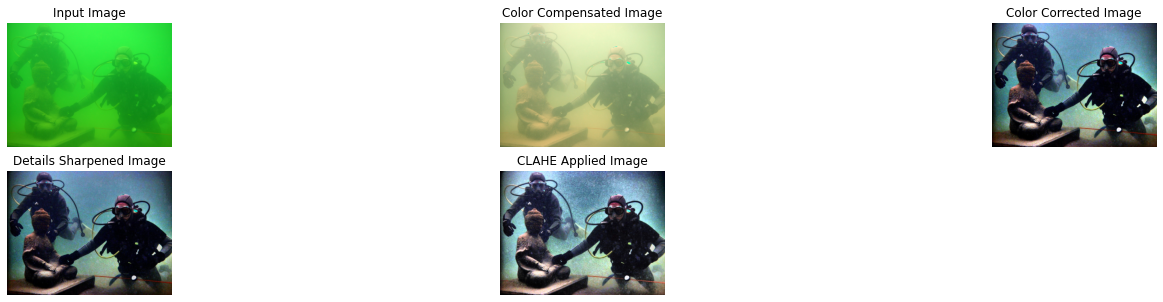

PSNR =  8.915165119786403
SSIM =  0.28484506392692327
Information Entropy =  7.751659297664081
UIQM =  1.2408896173278745
Average PSNR =  8.915165119786403
Average SSIM =  0.28484506392692327
Average Information Entropy =  7.751659297664081
Average UIQM =  1.2408896173278745


In [11]:
inpath = r'C:\Users\ardenus\Downloads\images'
outpath = r'C:\Users\ardenus\Downloads\Clahe'
ccom = r'C:\Users\ardenus\Downloads\ColorCompensation'
ccor = r'C:\Users\ardenus\Downloads\ColorCorrection'
shar = r'C:\Users\ardenus\Downloads\Sharpened'
a_uiqm = a_psnr = a_ssim = a_entropy = count =0
images = input("Enter the images to process:").split()
for i in images:
    name,ext = i.split(".")
    j = "\\"+i
    plt.figure(figsize=(25,5))
    
    img = cv2.imread(inpath+j)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    
#     plt.subplot(151)
#     plt.axis('off')
#     plt.imshow(img)
#     plt.title("Input Image")
    
    # Applying Color Compensation
    compensated = color_compensation(img)
    cv2.imwrite(ccom+j,compensated)
    
    # Applying Color Correction
    corrected = color_correction(cv2.imread(ccom+j),ext)
    cv2.imwrite(ccor+j,corrected)
    
    # Applying Details Sharpening
    sharpened = enhance(cv2.imread(ccor+j),5)
    cv2.imwrite(shar+j,sharpened)
    
    # Applying CLAHE
    ime = cv2.cvtColor(cv2.imread(shar+j),cv2.COLOR_BGR2Lab)
    #ime = cv2.cvtColor(ime,cv2.COLOR_RGB2Lab)
    clahe = cv2.createCLAHE(clipLimit = 3.0,tileGridSize=(4,4))
    ime[:,:,0] = clahe.apply(ime[:,:,0])
    ime = cv2.cvtColor(ime,cv2.COLOR_Lab2BGR)
    cv2.imwrite(outpath+j,ime)
    
    
    
    plt.subplot(231)
    plt.axis('off')
    plt.imshow(mpimg.imread(inpath+j))
    plt.title("Input Image")
    
    plt.subplot(232)
    plt.axis('off')
    plt.imshow(mpimg.imread(ccom+j))
    plt.title("Color Compensated Image")
    
    plt.subplot(233)
    plt.axis('off')
    plt.imshow(mpimg.imread(ccor+j))
    plt.title("Color Corrected Image")
    
    
    plt.subplot(234)
    plt.axis('off')
    plt.imshow(mpimg.imread(shar+j))
    plt.title("Details Sharpened Image")
    
    
    plt.subplot(235)
    plt.axis('off')
    plt.imshow(mpimg.imread(outpath+j))
    plt.title("CLAHE Applied Image")
    plt.show()
    
    # Calculating PSNR, SSIM, Information Entropy,UIQM
    count+=1
    
    input_image = Image.open(inpath+j)
    input_image = cv2.cvtColor(np.array(input_image),cv2.COLOR_RGB2BGR)
    
    processed_image = Image.open(outpath+j)
    processed_image = cv2.cvtColor(np.array(processed_image),cv2.COLOR_RGB2BGR)
    
    entropy = get_entropy(cv2.imread(outpath+j,0))
    
    warnings.filterwarnings('ignore')
    uiqm = get_uiqm(io.imread(outpath+j))
    
    
    psnr = cv2.PSNR(processed_image,input_image)
    SSIM = ssim(cv2.cvtColor(processed_image,cv2.COLOR_BGR2GRAY),cv2.cvtColor(input_image,cv2.COLOR_BGR2GRAY))
    
    print("PSNR = ",psnr)
    print("SSIM = ",SSIM)
    print("Information Entropy = ",entropy)
    print("UIQM = ",uiqm)
    
    a_psnr = a_psnr + psnr
    a_ssim = a_ssim + SSIM
    a_entropy = a_entropy + entropy
    a_uiqm = a_uiqm + uiqm
    

print("Average PSNR = ",(a_psnr/count))
print("Average SSIM = ",(a_ssim/count))
print("Average Information Entropy = ",(a_entropy/count))
print("Average UIQM = ",(a_uiqm/count))    